In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from sklearn.metrics import adjusted_rand_score

from glob import glob as glob


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from csw2022 import *

In [3]:
## include information about tonode response in dataframes
dfL = []
for cidx in range(2):
  condition = ['interleaved','interleaved_rep'][cidx]
  _df = load_final_df(condition)

  # if true on right, right_node = true_tonode
  for i,d in _df.iterrows():
    ## find right node and left node
    _df.loc[i,'right_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][int(d.true_on_right)]
    ]
    _df.loc[i,'left_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][np.abs(1-int(d.true_on_right))]
    ]

  ## find response node
  for i,df_row in _df.iterrows():
    _df.loc[i,'response_state'] = [df_row.left_state,df_row.right_state][int(df_row.response_right)]

  ## schema index
  _df.loc[:,'schema_idx'] = (_df.true_rfc.str.split('_').str[-1].str.split('-').str[1] == 'jungle').astype(int)
  dfL.append(_df)

  ## 
df_i,df_ir = dfL


-loading code version: RT01B1000cl
N = 55 subjects

-loading code version: csw1000block01.04.25.19
N = 56 subjects


In [4]:
dfD = {'interleaved':df_i,'interleaved_rep':df_ir}

In [5]:
subnumsD = {
  'interleaved': df_i.index.get_level_values('subjnum').unique().values,
  'interleaved_rep':df_ir.index.get_level_values('subjnum').unique().values
}
subnumsD

{'interleaved': array([ 1,  3,  5,  8,  9, 11, 12, 13, 16, 20, 21, 23, 24, 25, 27, 28, 29,
        30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48,
        49, 50, 51, 53, 54]),
 'interleaved_rep': array([ 1,  2,  4,  5,  6,  9, 10, 13, 14, 15, 17, 19, 21, 26, 27, 34, 40,
        42, 44, 48, 49, 52, 54, 55])}

### dataframe processing

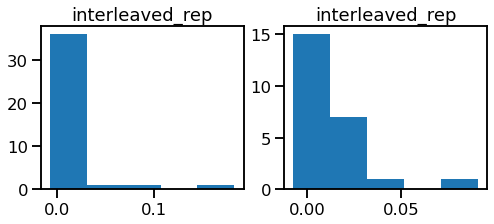

In [6]:
fg,axar = plt.subplots(1,2,figsize=(8,3))
for cidx in range(2):
  ax = axar[cidx]
  df = dfL[cidx]
  ## compute adjusted rand (only for 3/4=>5/6)
  adjrandL = []
  for idx, sub_df in df.groupby('subjnum'):
    for jdx, sub_depth_df in sub_df.groupby('depth'):
      if jdx == 2: continue
      sub_ar = adjusted_rand_score(
        sub_depth_df.response_state.values,
        sub_depth_df.schema_idx.values
      )
      adjrandL.append(sub_ar)
      
  ## plot
  adjRand = np.array(adjrandL)
  ax.hist(adjRand,bins=5)
  ax.set_title(condition)
#   plt.savefig('figures/interleaved-adjrand')

# moving window adjusted rand

In [7]:
def windowed_ar(X,Y,window):
  assert len(X)==len(Y)
  AR = -np.ones(len(X)-window)
  for wi in range(len(X)-window):
    AR[wi] = adjusted_rand_score(
      X[wi:wi+window],
      Y[wi:wi+window]
    )
  return AR

In [8]:


def compute_windowed_adjrand(df,window=20):
  """ returns list of list because 
  different subjects have different number of timepoints
  """
  subnums = df.index.get_level_values('subjnum').unique()
  Nsubs = subnums.shape[0]
  marLoL = []
  for idx,(sidx,sub_df) in enumerate(df[df.index.get_level_values('depth')==2].groupby(['subjnum'])):
    sub_win_ar = windowed_ar(
      sub_df.response_state.values,
      sub_df.schema_idx.values,
      window
    )
    marLoL.append(sub_win_ar)
  return marLoL


# cidx = 1
# condition = ['interleaved','interleaved_rep'][cidx]
# df = [df_i,df_ir][cidx]

# warL = compute_windowed_adjrand(df,window=20)
# len(warL),warL[0].shape # each subject one array (varying length) in list

In [9]:
# subnums = df.index.get_level_values('subjnum').unique()
# fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True);axarr=axarr.reshape(-1)
# for idx in range(len(warL)):
#   ax=axarr[idx]
#   ax.set_title(subnums[idx])
#   ax.plot(warL[idx])
#   ax.axhline(0,c='k',ls='--')
#   ax.set_xticklabels([])

In [10]:
def compute_null_windowed_adjrand(df,window,nitr):
  """ returns list of arrays  
  each subject has an array of null values for that subject's experiment sequence
  subjects have different number of timepoints
  """
  subnums = df.index.get_level_values('subjnum').unique()
  Nsubs = subnums.shape[0]
  marLoA = []
  # loop over subjects
  for idx,(sidx,sub_df) in enumerate(df[df.index.get_level_values('depth')==2].groupby(['subjnum'])):
    # loop over itr
    sub_exp_len = sub_df.shape[0]
    null_sub_resp = np.random.choice([2,3],[nitr,sub_exp_len])
    null_sub_AR = -np.ones([nitr,sub_exp_len-window])
    for itr in range(nitr):
      null_sub_AR[itr] = windowed_ar(
        sub_df.schema_idx.values,
        null_sub_resp[itr],
        window=window
      )
      
    marLoA.append(null_sub_AR)
  return marLoA


# null_warL = compute_null_windowed_adjrand(df_i,window=20,nitr=100)
# len(null_warL),null_warL[0].shape,null_warL[1].shape

In [11]:
def war_metric(sub_war,null_sub_war,threshold=0.05):
  """ 
  sub_war: 1d array [exp_len-window] subject windowed ar
  null_sub_war: 2d array [itr,exp_len-window], nitr nulls for sub
  returns: sub_metric, metric_null_distr
  """
  sub_metric = np.sum(sub_war>threshold)
  null_distr_metric = np.sum(null_sub_war>threshold,1)
  return sub_metric,null_distr_metric

# def war_metric_group()

In [12]:
# ## compute and save windowed adjrand
# nitr_null = 100
# for cidx in range(2):
#   print('cond',cidx)
#   condition = ['interleaved','interleaved_rep'][cidx]
#   df = [df_i,df_ir][cidx]
#   subnums = df.index.get_level_values('subjnum').unique()
#   for window in [5,20]:
#     print('window',window)
#     warL = compute_windowed_adjrand(df,window)
#     null_warL = compute_null_windowed_adjrand(df,window,nitr_null)
#     for idx,sidx in enumerate(subnums):
#       sub_war = warL[idx]
#       sub_null_war = null_warL[idx]
#       np.save('analysis_data/window_ajusted_rand/s%.2i-war-window_%.2f-%s'%(
#         sidx,window,condition),
#               sub_war
#              )
#       np.save('analysis_data/window_ajusted_rand/s%.2i-null_war-window_%.2f-%s'%(
#         sidx,window,condition),
#               sub_null_war
#              )

### GENERATE KDE PLOTS 

In [13]:

# from glob import glob as glob


# def make_war_kdeplt(warL,null_warL,thresh,subnums):
#   plt.close('all')
#   fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True,sharex=True);axarr=axarr.reshape(-1)
#   for idx in range(len(warL)):
#     ## get subject data
#     sub_war = warL[idx]
#     null_sub_war = null_warL[idx]
#     ## metric
#     sub_metric,null_distr_metric = war_metric(sub_war,null_sub_war,thresh)
#     prop = np.mean(sub_metric > null_distr_metric)
#     ## plot
#     ax=axarr[idx]
#     ax.set_title("S%i rank=%.2f"%(subnums[idx],prop))
#     ## 
#     sns.kdeplot(null_distr_metric,ax=ax)
#     ax.axvline(sub_metric,c='r')
#     ax.axvline(0,c='k')
#   return None
    

  
  
# for condition in ['interleaved','interleaved_rep']:
#   for window in [5,20]:
#     for thresh in [0.05,0.75,0.1]:
#       print(condition,window,thresh)

#       war_fpath = lambda sidx: 'analysis_data/window_ajusted_rand/s%.2i-war-window_%.2f-%s.npy'%(sidx,window,condition)
#       war_null_fpath = lambda sidx: 'analysis_data/window_ajusted_rand/s%.2i-null_war-window_%.2f-%s.npy'%(sidx,window,condition)

#       warL = [np.load(war_fpath(sidx)) for sidx in subnumsD[condition]] 
#       null_warL = [np.load(war_null_fpath(sidx)) for sidx in subnumsD[condition]] 

#       make_war_kdeplt(warL,null_warL,thresh,subnumsD[condition])
#       plt.savefig('figures/kde_mov_ar-window_%i-metric_thresh_%.2f-%s.png'%(window,thresh,condition))




### kde plot separated by group acc

In [14]:
## funs for subdividing subjects into groups based on acc

def get_sub_test_acc(cond,subnum):
  return np.load('analysis_data/accuracy/%s-s%i-block_acc.npy'%(cond,subnum))[-1]

def get_cond_test_acc(cond):
  from glob import glob as glob
  fpathL = glob('analysis_data/accuracy/%s-s*-block_acc.npy'%cond)
  return np.mean([np.load(fpath)[-1] for fpath in fpathL])


def get_subnums_by_meanacc_group(cond):
  """returns subnums above and below mean acc"""
  groupM = get_cond_test_acc(cond)
  aboveM = []
  belowM = []
  for subnum in subnumsD[cond]:
    sub_test_acc = get_sub_test_acc(cond,subnum)
    if sub_test_acc > groupM:
      aboveM.append(subnum)
    else:
      belowM.append(subnum)
  return aboveM,belowM


In [15]:
def make_acc_plots(condition,subnums,ma_window=10):
  df = dfD[condition]
  acc = df.correct_response.groupby(['subjnum']).apply(mov_avg,ma_window)  
  plt.close('all')
  fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True,sharex=True);axarr=axarr.reshape(-1)
  idx=0
  for sidx,sub_acc in acc.iteritems():
    if sidx not in subnums: continue
    ax=axarr[idx]
    ax.plot(sub_acc)
    idx+=1
    ax.set_title("S%i"%(sidx))
    ax.axhline(0.5)
  return None

def make_war_kdeplt(warL,null_warL,thresh,subnums):
  plt.close('all')
  fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True,sharex=True);axarr=axarr.reshape(-1)
  for idx in range(len(warL)):
    ## get subject data
    sub_war = warL[idx]
    null_sub_war = null_warL[idx]
    ## metric
    sub_metric,null_distr_metric = war_metric(sub_war,null_sub_war,thresh)
    prop = np.mean(sub_metric > null_distr_metric)
    ## plot
    ax=axarr[idx]
    ax.set_title("S%i adj_rand_rank=%.2f"%(subnums[idx],prop))
    ## 
    sns.kdeplot(null_distr_metric,ax=ax)
    ax.axvline(sub_metric,c='r')
    ax.axvline(0,c='k')
  return None

interleaved aboveM [3, 5, 8, 11, 21, 23, 24, 27, 28, 30, 32, 41, 43, 44]
interleaved 20 0.1
interleaved belowM [1, 9, 12, 13, 16, 20, 25, 29, 31, 34, 35, 36, 37, 38, 39, 40, 42, 45, 47, 48, 49, 50, 51, 53, 54]
interleaved 20 0.1
interleaved_rep aboveM [2, 5, 6, 10, 15, 26, 27, 49, 55]
interleaved_rep 20 0.1
interleaved_rep belowM [1, 4, 9, 13, 14, 17, 19, 21, 34, 40, 42, 44, 48, 52, 54]
interleaved_rep 20 0.1


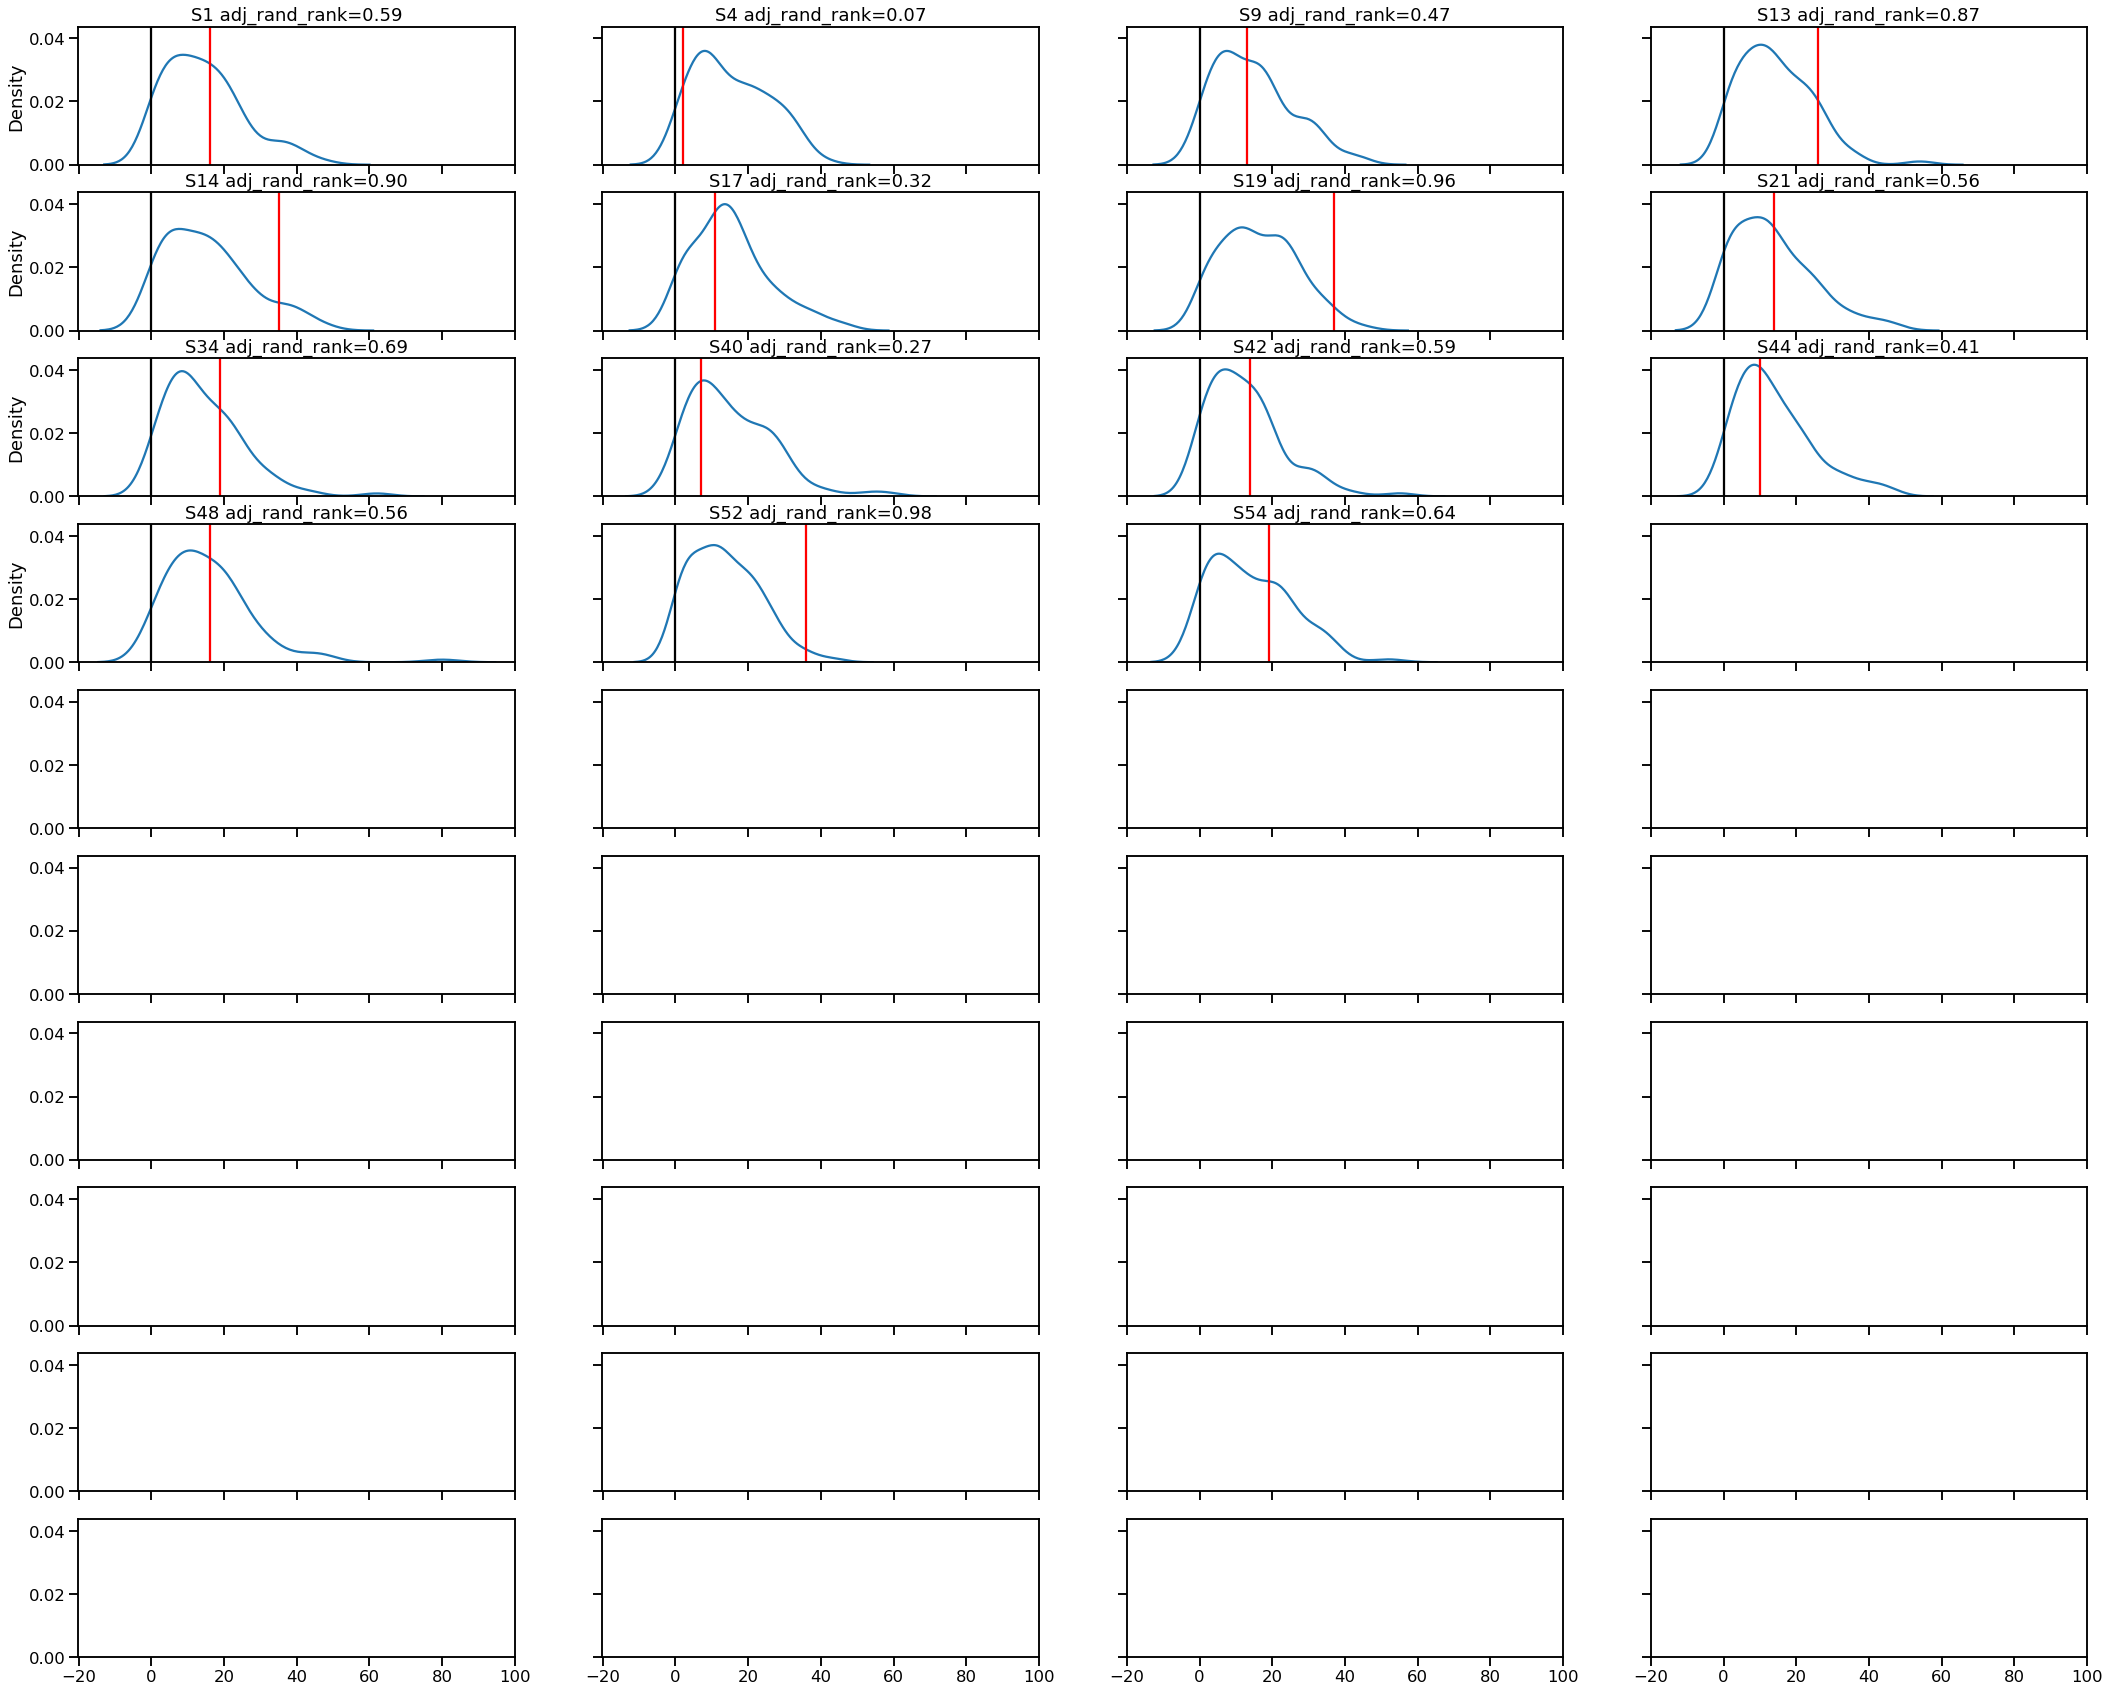

In [17]:
threshL = [0.1]
windowL = [20]
  
for condition in ['interleaved','interleaved_rep']:  
  for sub_group_idx in range(2):
    ## get subject numbers for subjects above vs below 
    group_label = ['aboveM','belowM'][sub_group_idx]
    subnums = get_subnums_by_meanacc_group(condition)[sub_group_idx]
    print(condition,group_label,subnums)
    ## accuracy 
    ma_window=15
    make_acc_plots(condition,subnums,ma_window)
    plt.savefig('figures/acc-MAwindow_%i-%s-subs_%s.png'%(
          ma_window,condition,group_label))
    ## kde plots of windowed adjusted rand
    for window in windowL:
      ## lambda for grabbing windowed adj rand data
      war_fpath = lambda sidx:\
      'analysis_data/window_ajusted_rand/s%.2i-war-window_%.2f-%s.npy'%(
        sidx,window,condition)
      war_null_fpath = lambda sidx:\
      'analysis_data/window_ajusted_rand/s%.2i-null_war-window_%.2f-%s.npy'%(
        sidx,window,condition)
      
      ## make plots for different thresholds
      for thresh in threshL:
        print(condition,window,thresh)

        warL = [np.load(war_fpath(sidx)) for sidx in subnums] 
        null_warL = [np.load(war_null_fpath(sidx)) for sidx in subnums] 
        make_war_kdeplt(warL,null_warL,thresh,subnums)
        plt.savefig('figures/kde_mov_ar-window_%i-metric_thresh_%.2f-%s-subs_%s.png'%(
          window,thresh,condition,group_label))


